In [1]:
import pyreadr
import scanpy as sc
import numpy as np
import os
import pandas as pd
import anndata as ad
import scrublet as scr
from pathlib import Path

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

In [2]:
# where to save the file and filename to give
DIR2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/scrublet_qc/")
DIR2SAVE.mkdir(parents=True, exist_ok=True)

scrublet_filename = "Wu2022_CRC_LM_scrublet.txt"

# figures path to save
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [3]:
adata = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/raw/Wu2022_CRC_LM_raw.h5ad"
)

In [4]:
set(adata.obs.Tissue)

{'LM'}

In [5]:
len(set(adata.obs.Patient))

20

In [6]:
adata.obs[["Therapy", "Patient"]].drop_duplicates(
    subset=["Therapy", "Patient"], inplace=False
).groupby("Therapy").size()

Therapy
NAC       9
naive    11
dtype: int64

### run scrublet per sample and on raw data
* When working with data from multiple samples, run Scrublet on each sample separately. Because Scrublet is designed to detect technical doublets formed by the random co-encapsulation of two cells, it may perform poorly on merged datasets where the cell type proportions are not representative of any single sample.

In [7]:
adata.obs

,Sample,nCount_RNA,nFeature_RNA,patient,tissue,patient_tissue,tissueunique,RNA_snn_res.0.5,seurat_clusters,RNA_snn_res.0.1,doublet,RNA_snn_res.1,Cell_type,Cell_subtype,chemo,Therapy,Patient,Tissue
barcode,,,,,,,,,,,,,,,,,,
P11_Liver_T_TACCTGCTCAGCAATC,P11_Liver_T,2265,974,P11,Liver_T,P11_Liver_T,Liver_T,1,1,0,Singlet,3,CD4,CCR6+ Th17,pretreated,naive,Wu2021_P11,LM
P12_Liver_T_CATTGCCCATTCTCTA,P12_Liver_T,2919,1071,P12,Liver_T,P12_Liver_T,Liver_T,1,1,0,Singlet,3,CD4,CCR6+ Th17,pretreated,naive,Wu2021_P12,LM
P12_Liver_T_TCGAACAGTAACACGG,P12_Liver_T,2103,903,P12,Liver_T,P12_Liver_T,Liver_T,1,1,0,Singlet,3,CD4,CCL5+ CD4+ T cells,pretreated,naive,Wu2021_P12,LM
P12_Liver_T_GTCAGCGAGGAGATAG,P12_Liver_T,1580,765,P12,Liver_T,P12_Liver_T,Liver_T,1,1,0,Singlet,3,CD8,GZMK+ CD8+ T cells,pretreated,naive,Wu2021_P12,LM
P10_Liver_T2_GTTAGTGGTCGCATCG,P10_Liver_T2,3892,1368,P10,Liver_T2,P10_Liver_T2,Liver_T,2,2,0,Singlet,4,CD4,CCL5+ CD4+ T cells,pretreated,naive,Wu2021_P10,LM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P8_Liver_T_GAGAAATAGGCCTGAA,P8_Liver_T,17023,2624,P8,Liver_T,P8_Liver_T,Liver_T,5,5,3,Singlet,24,Plasma,IGHG+ Plasma B cells,pretreated,naive,Wu2021_P8,LM
P15_Liver_T_TTATTGCTCGCTAATG-1,P15_Liver_T,3453,903,P15,Liver_T,P15_Liver_T,Liver_T,5,5,3,Singlet,24,Plasma,IGHA+ Plasma B cells,treated-PD/SD,NAC,Wu2021_P15,LM
P17_Liver_T_AAATGGACATGGAAGC-1,P17_Liver_T,7002,1680,P17,Liver_T,P17_Liver_T,Liver_T,5,5,3,Singlet,24,Plasma,IGHG+ Plasma B cells,pretreated,naive,Wu2021_P17,LM


#### Check that the data is raw 

In [8]:
adata.X[1:5, 1:5].todense()

matrix([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=float32)

In [9]:
np.max(adata.X)

40676.0

#### run scrublet
scr.scrub_doublets() simulates doublets from the observed data and uses a k-nearest-neighbor classifier to calculate a continuous doublet_score (between 0 and 1) for each transcriptome. The score is automatically thresholded to generate predicted_doublets, a boolean array that is True for predicted doublets and False otherwise.

In [10]:
def run_scrublet(adata, sample_col="Sample", cellbarcode_index_name="level_1"):
    # create dict that stores scrublet results from each sample in adata
    scrublet_dict = {k: None for k in list(set(adata.obs[sample_col]))}

    # run scrublet per sample
    for sample in scrublet_dict.keys():
        print("Sample:", sample)
        adata_tmp = adata[adata.obs[sample_col] == sample].copy()
        scrub = scr.Scrublet(adata_tmp.X)
        (
            adata_tmp.obs["doublet_score"],
            adata_tmp.obs["predicted_doublet"],
        ) = scrub.scrub_doublets()
        scrub.plot_histogram()
        # sc.external.pp.scrublet(adata_tmp)
        scrublet_dict[sample] = adata_tmp.obs[
            ["Sample", "doublet_score", "predicted_doublet"]
        ]
        # sc.external.pl.scrublet_score_distribution(adata_tmp)

    # Put all scores in a single panda dataframe
    scrublet_concat = (
        pd.concat(scrublet_dict, axis=0)
        .reset_index()
        .drop(labels="level_0", axis=1)
        .set_index(cellbarcode_index_name)
    )

    return scrublet_concat

Sample: P10_Liver_T2
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 4.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.0%
Elapsed time: 2.3 seconds
Sample: P1_Liver_T
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 16.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.4%
Elapsed time: 0.4 seconds
Sample: P2_Liver_T
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neigh

Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 5.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.0%
Elapsed time: 1.0 seconds
Sample: P5_Liver_T2


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scrublet/scrublet.py:485: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize = fig_size)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 1.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.5%
Elapsed time: 0.7 seconds
Sample: P9_Liver_T2
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 6.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.3%
Elapsed time: 0.9 seconds
Sample: P7_Liver_T2
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatic

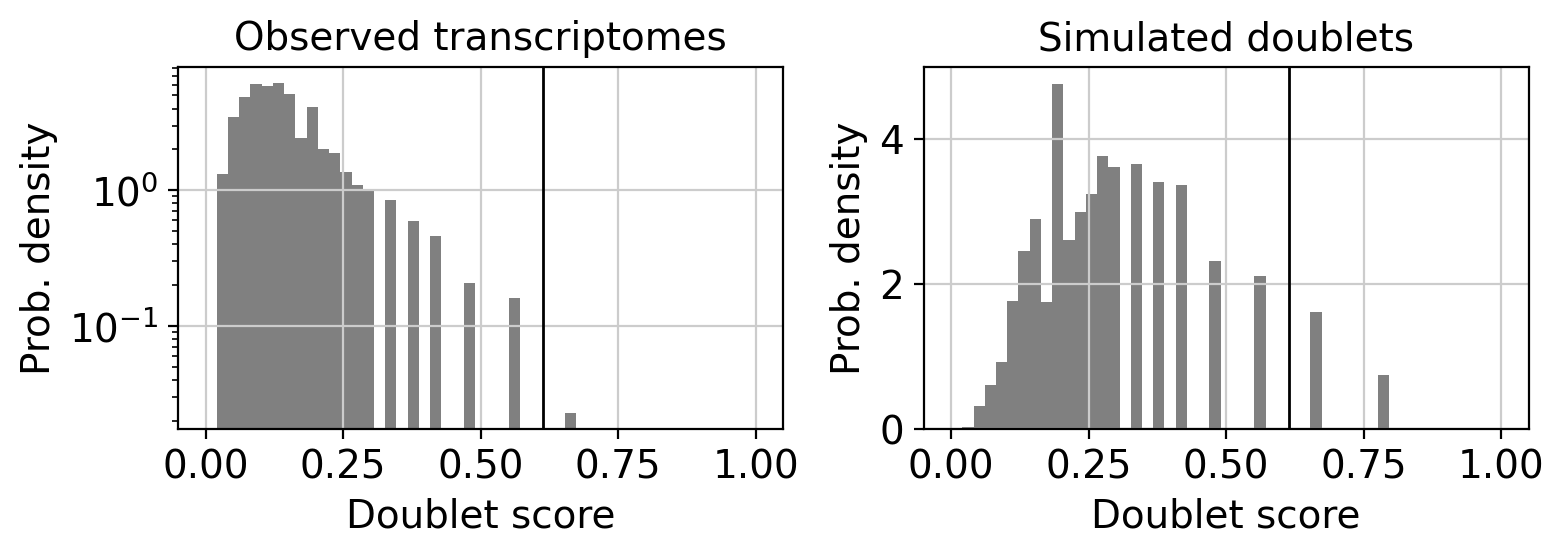

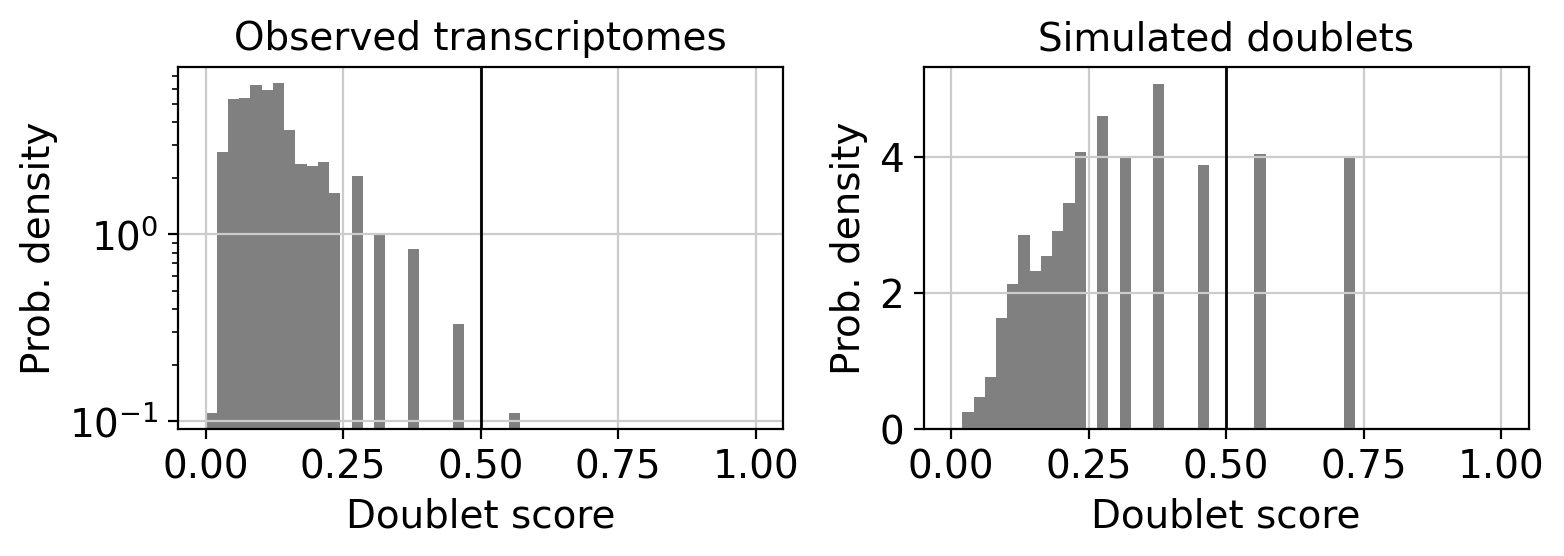

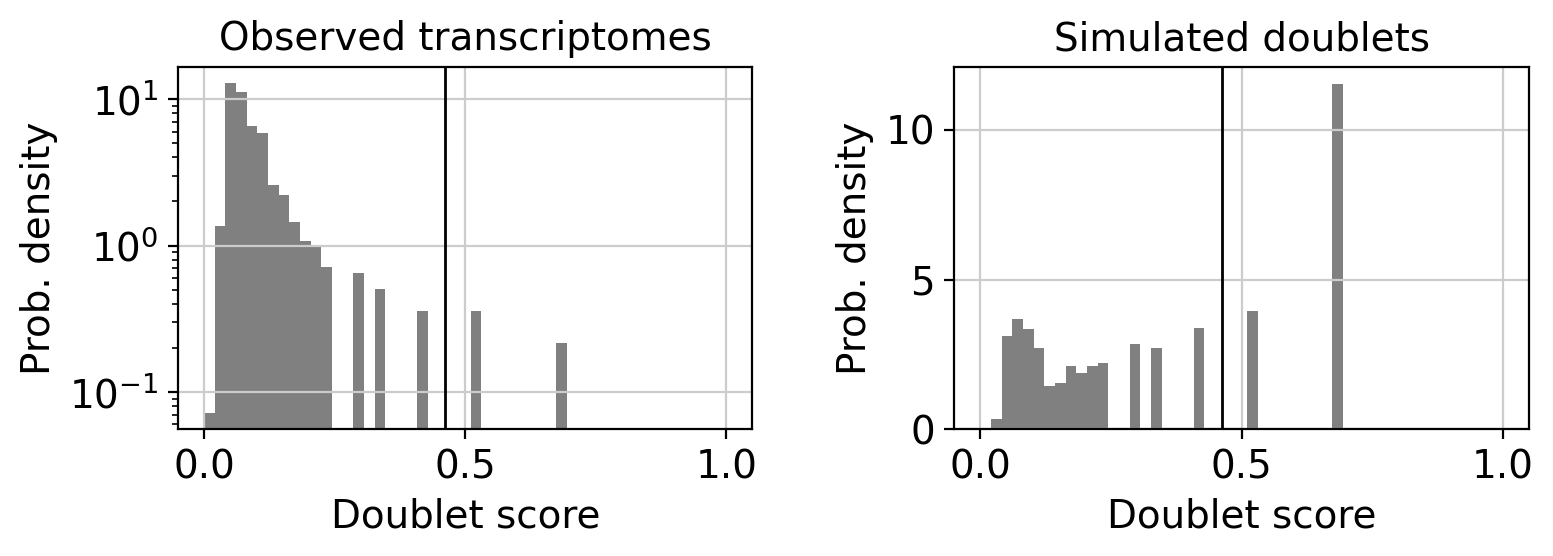

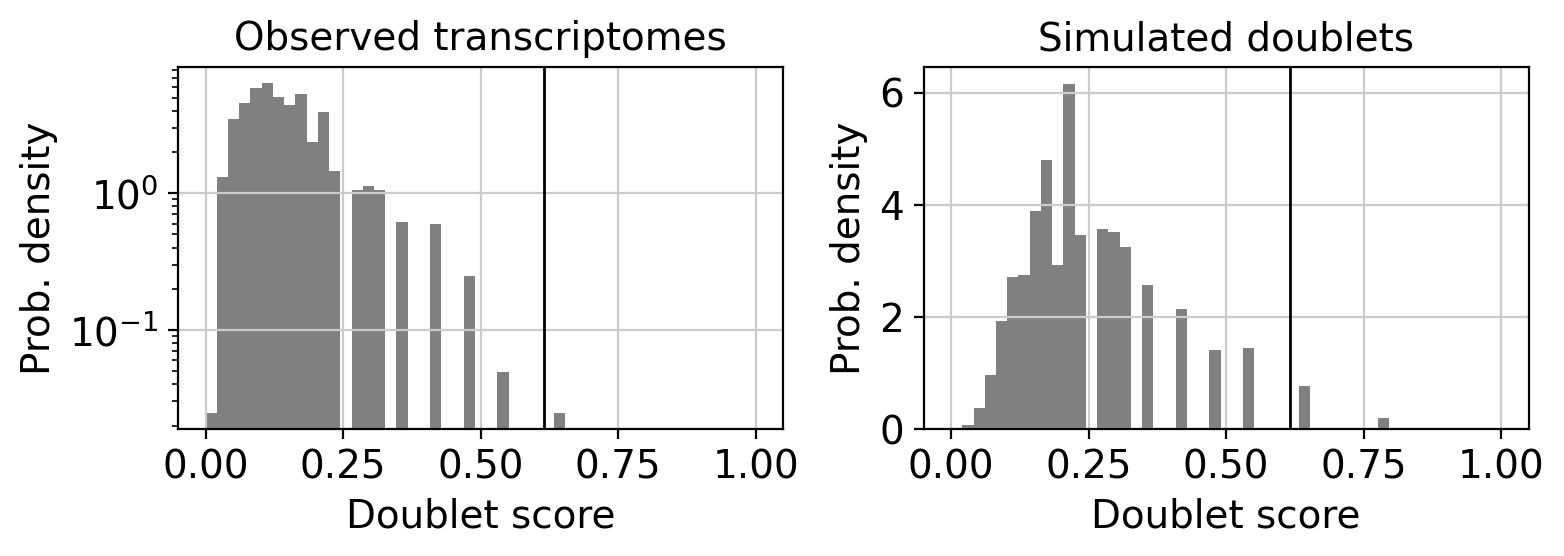

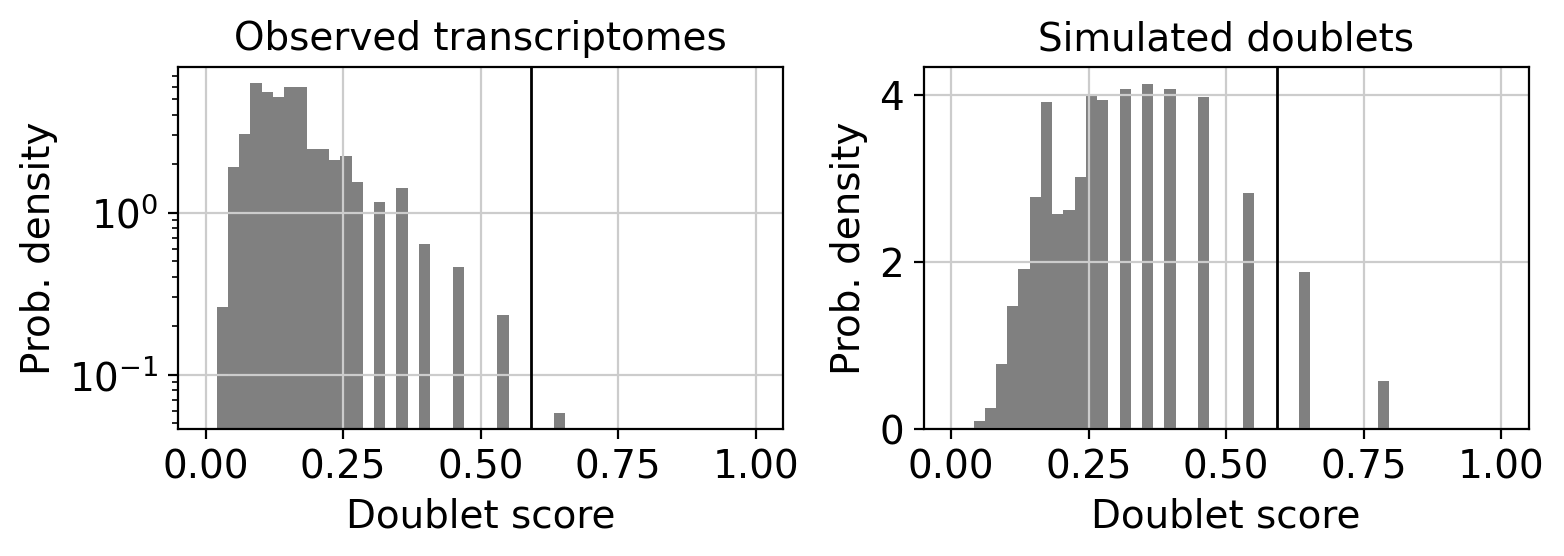

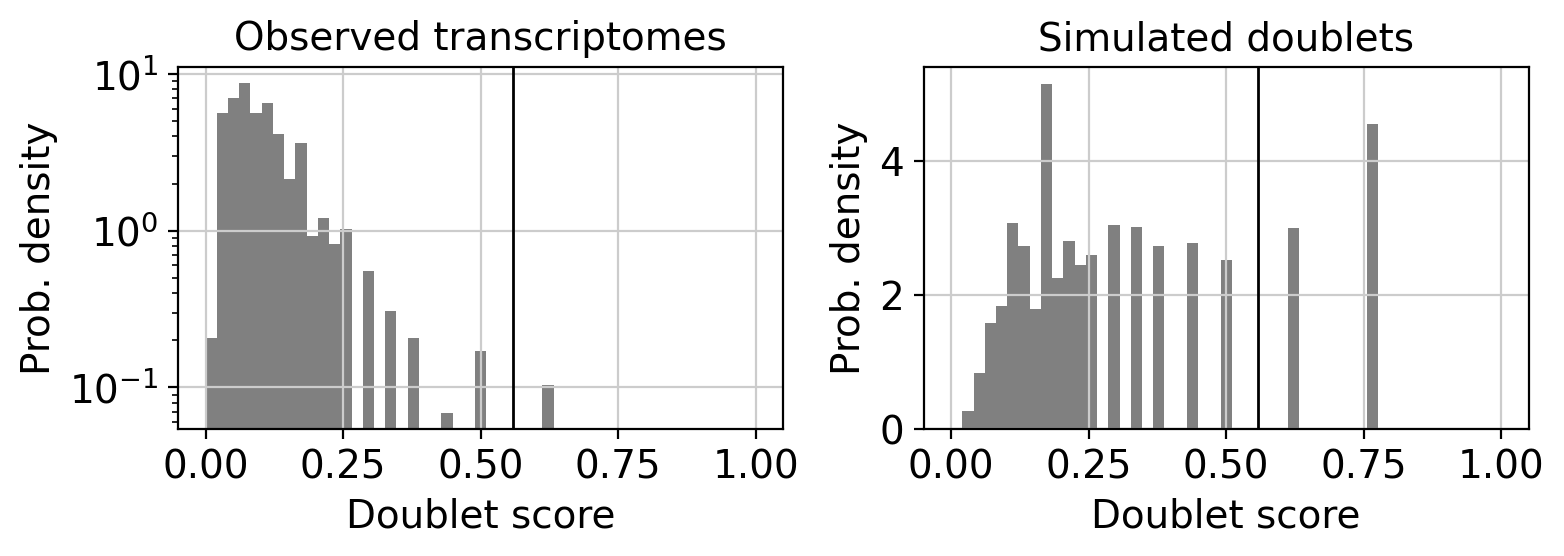

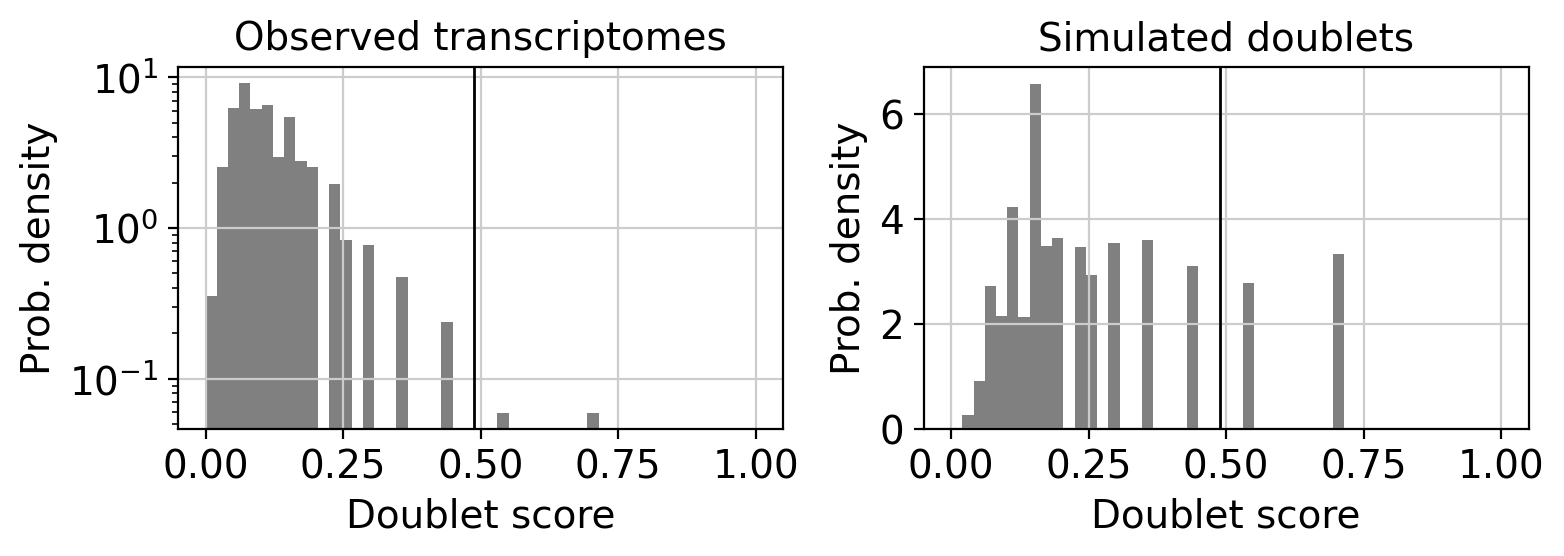

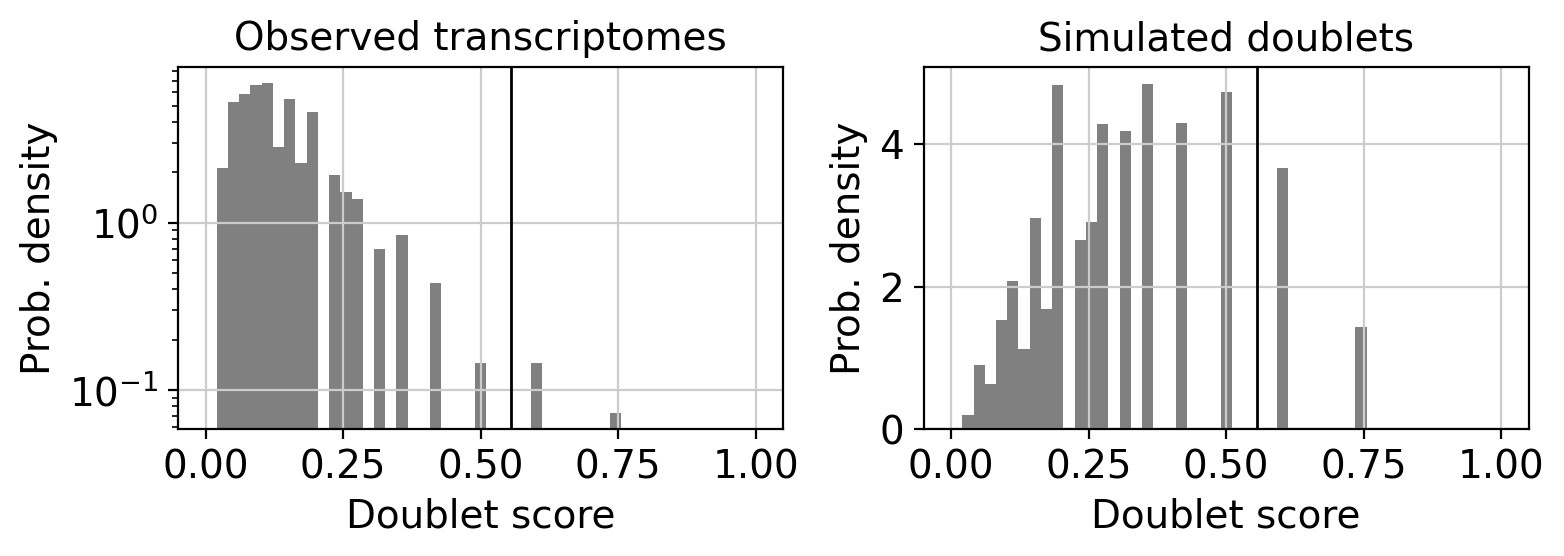

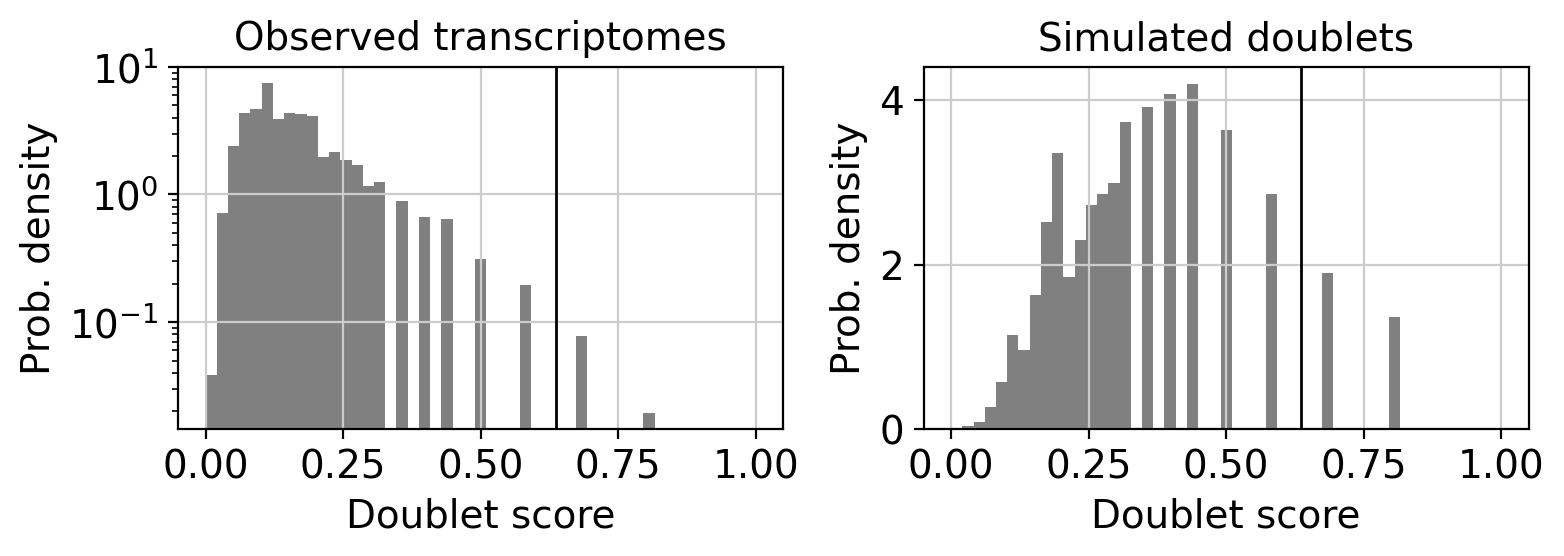

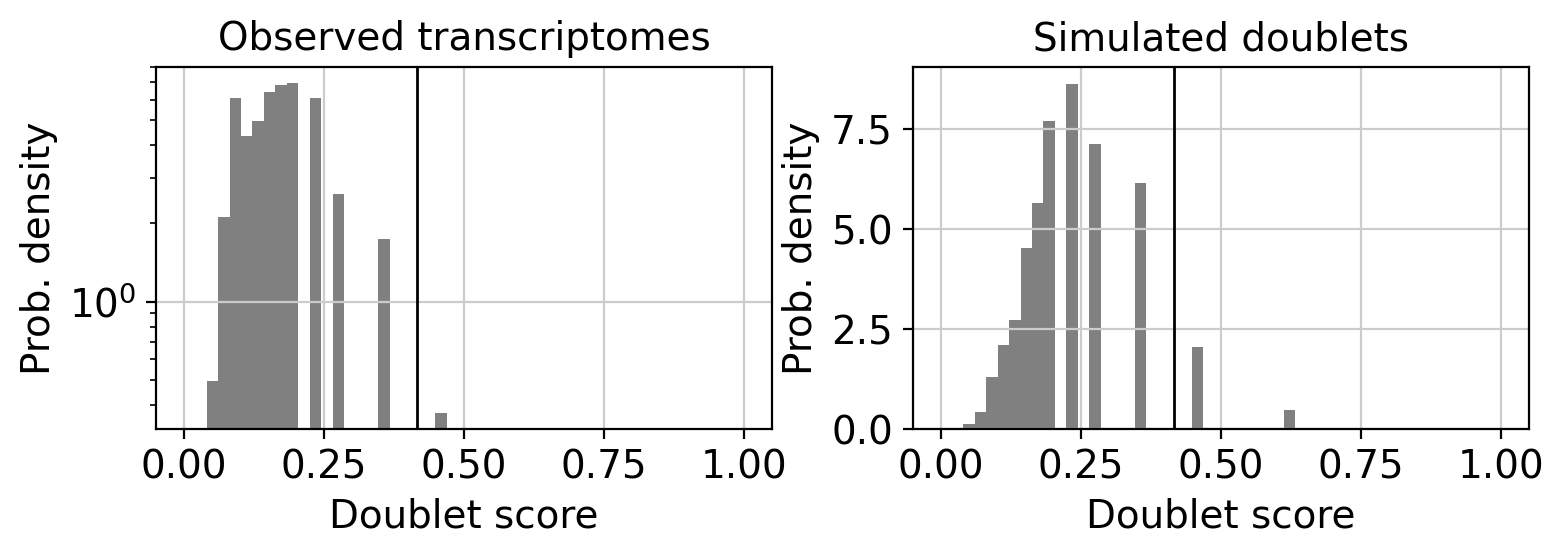

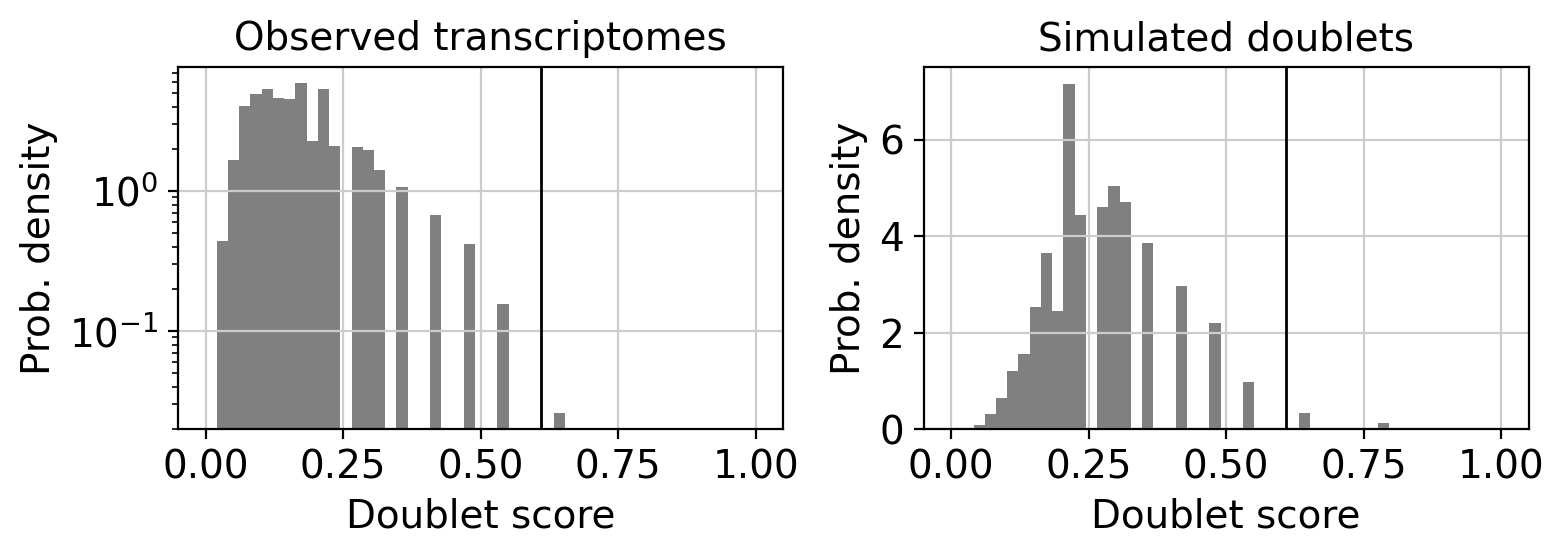

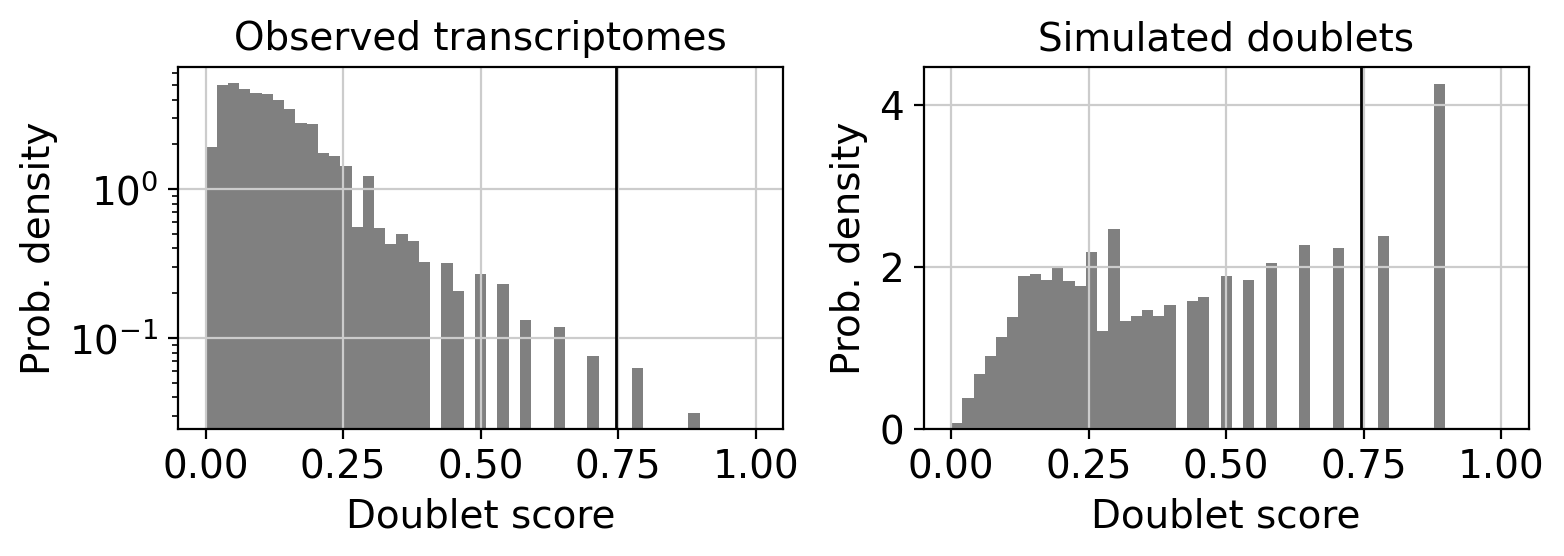

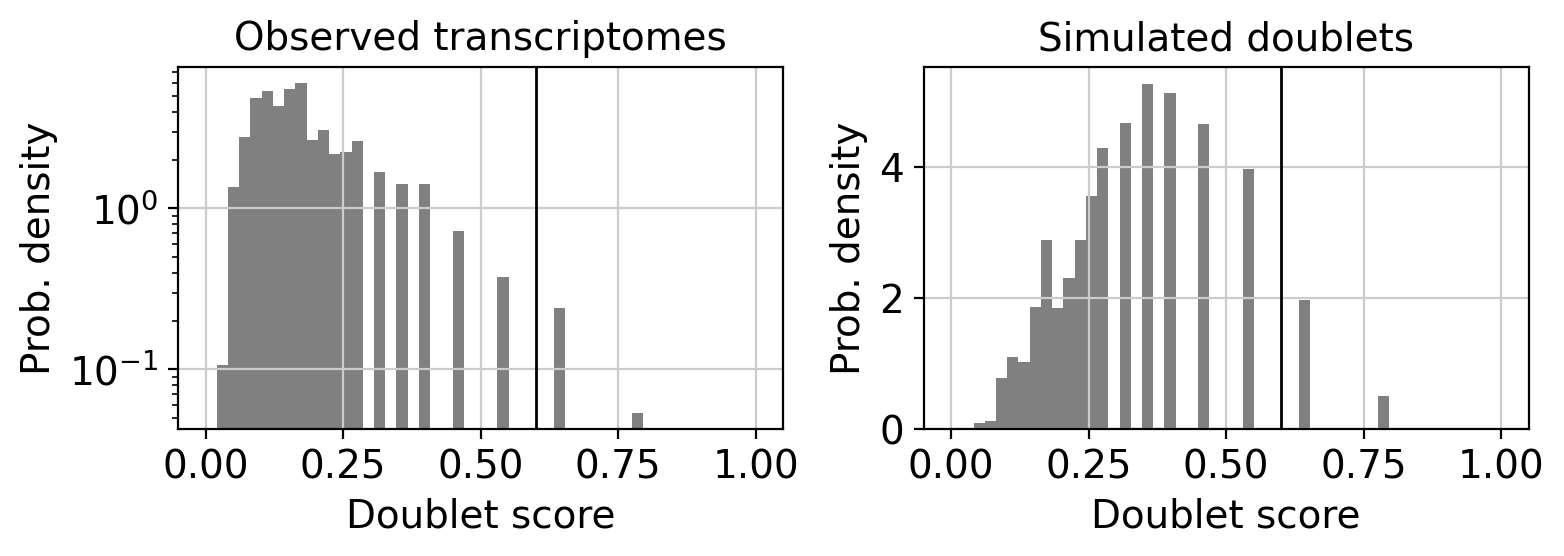

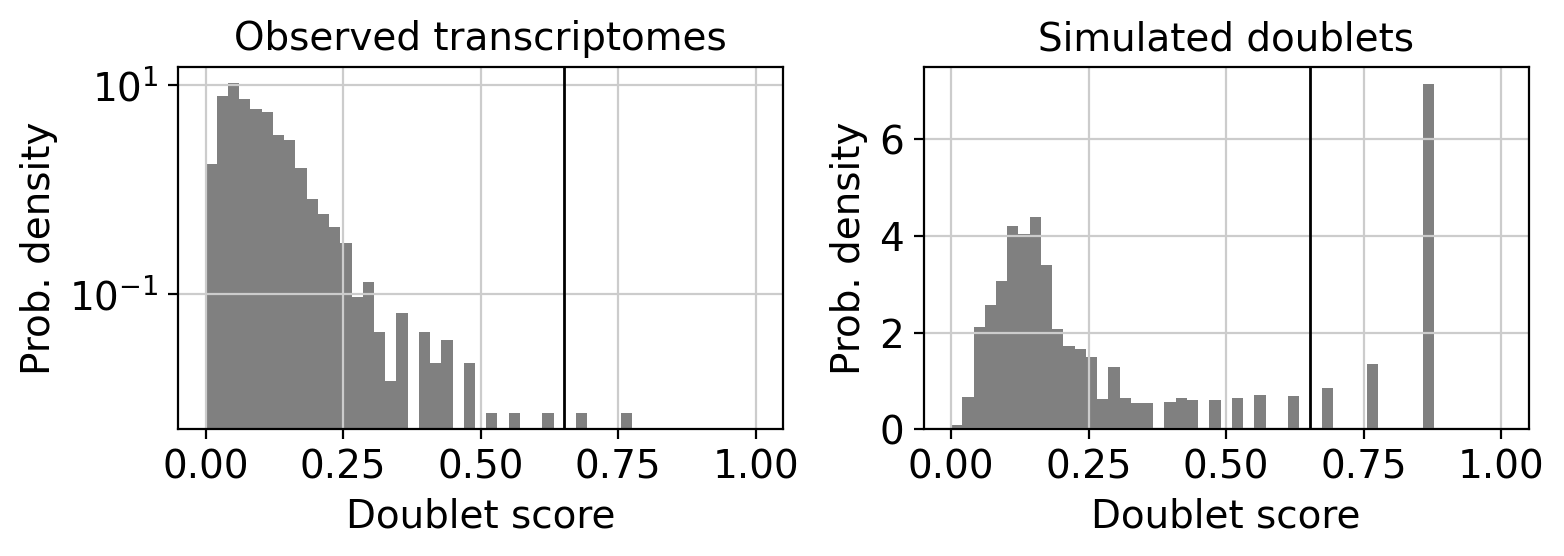

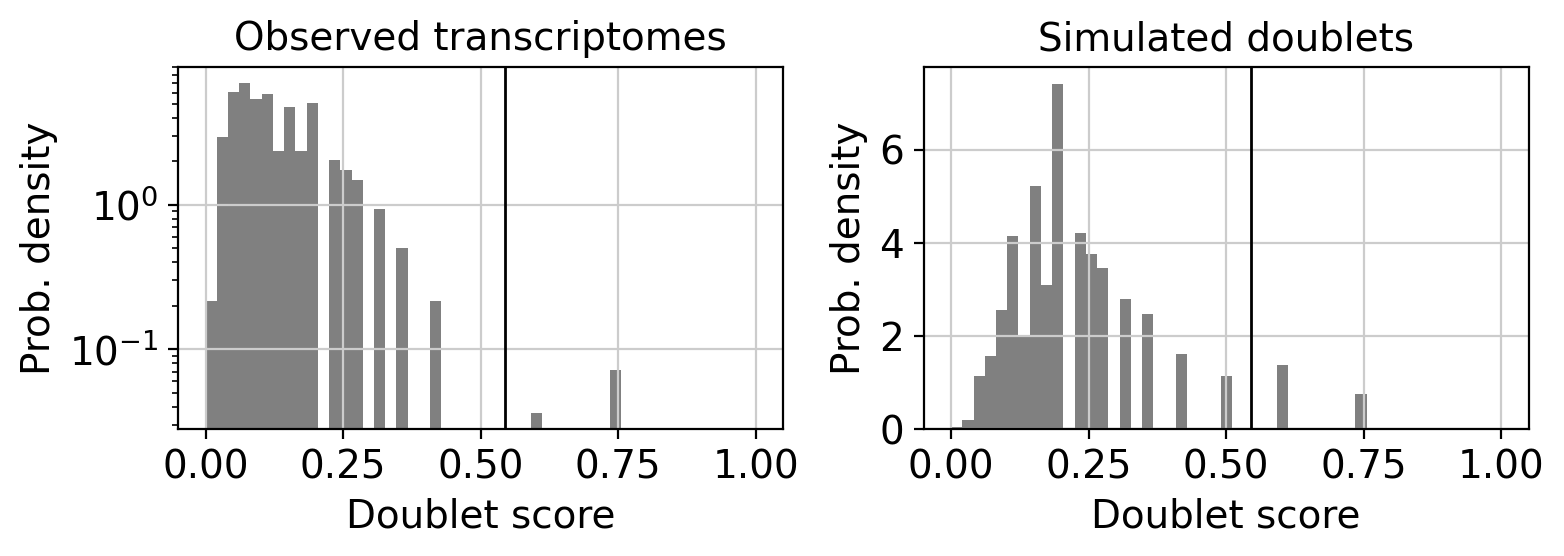

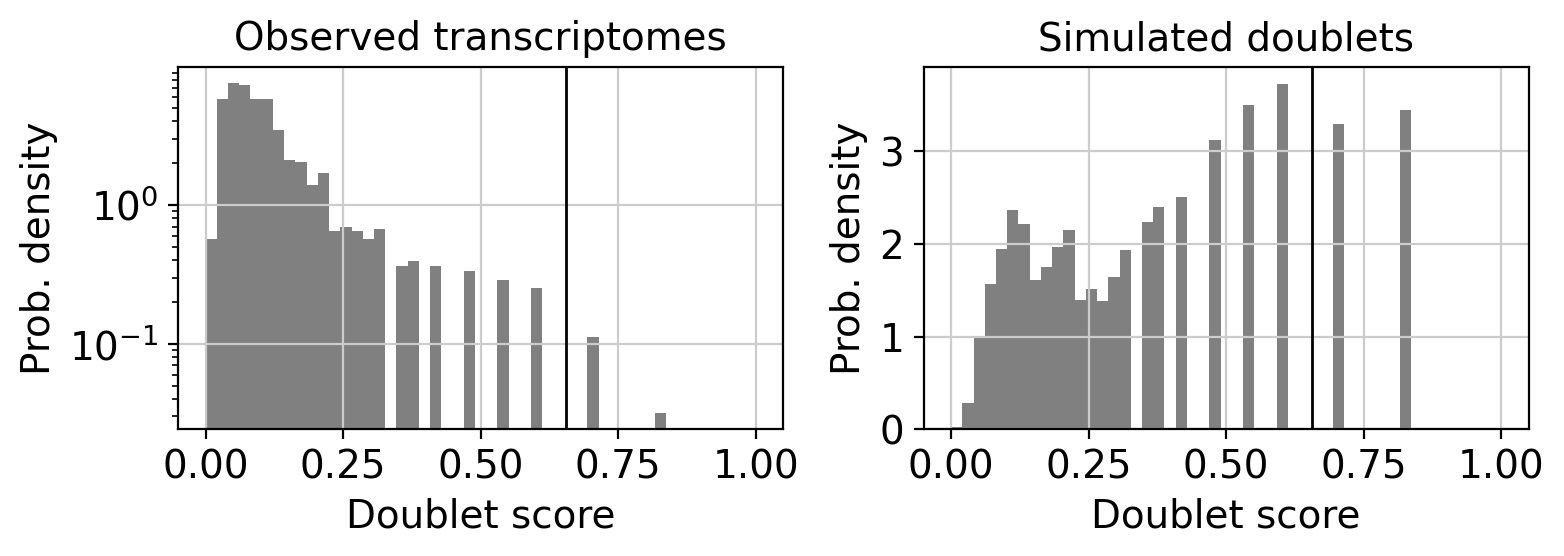

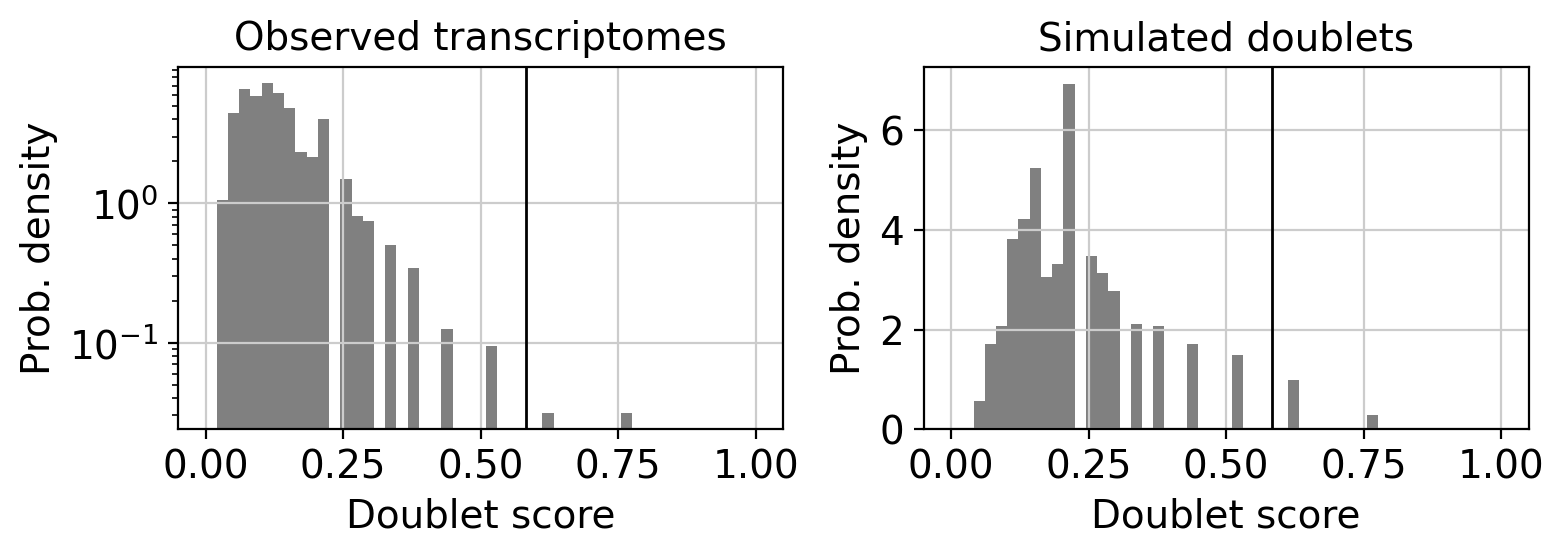

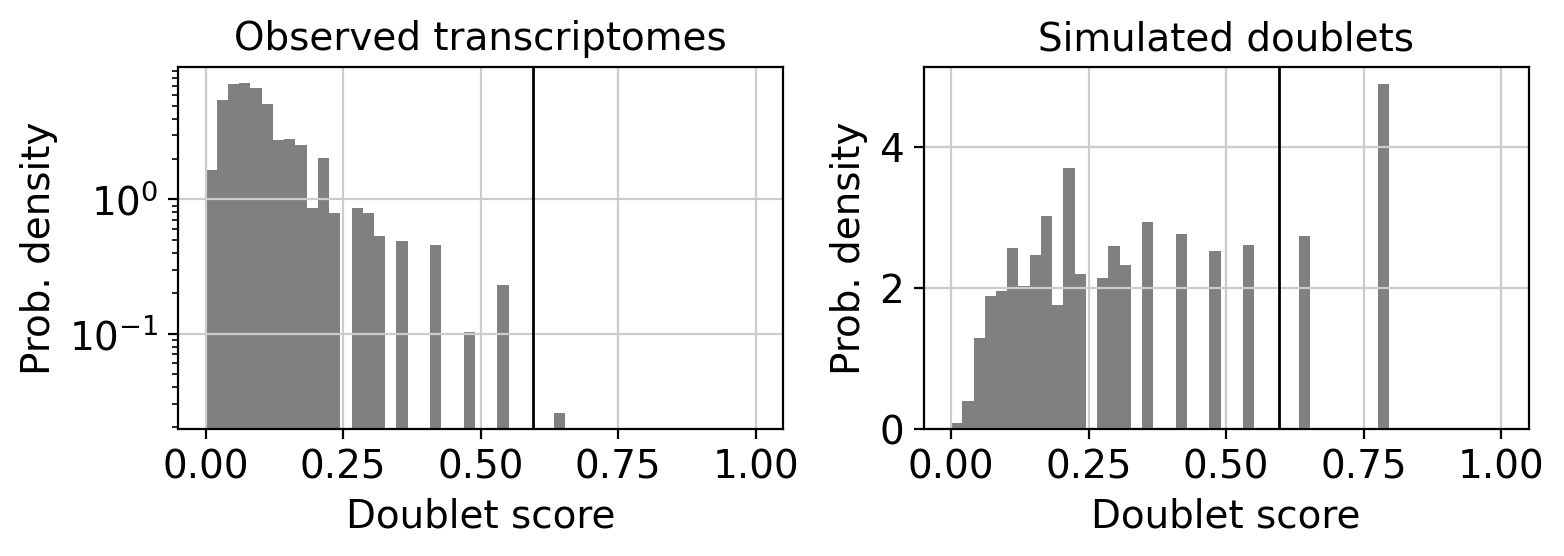

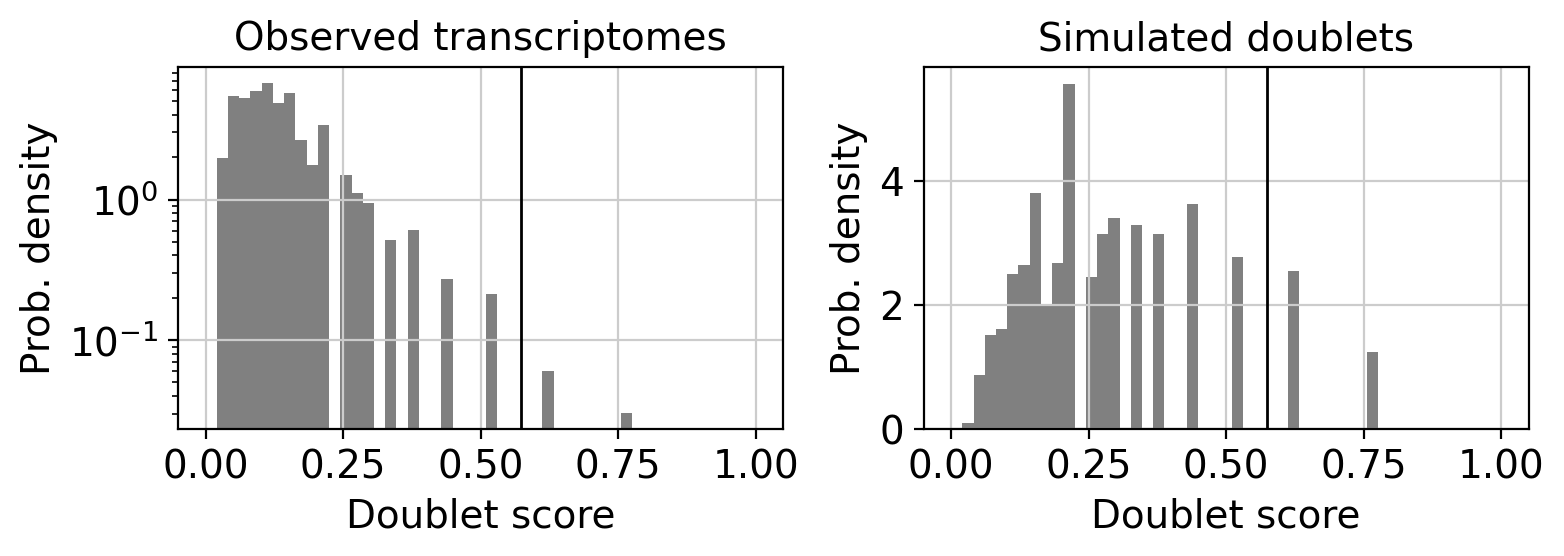

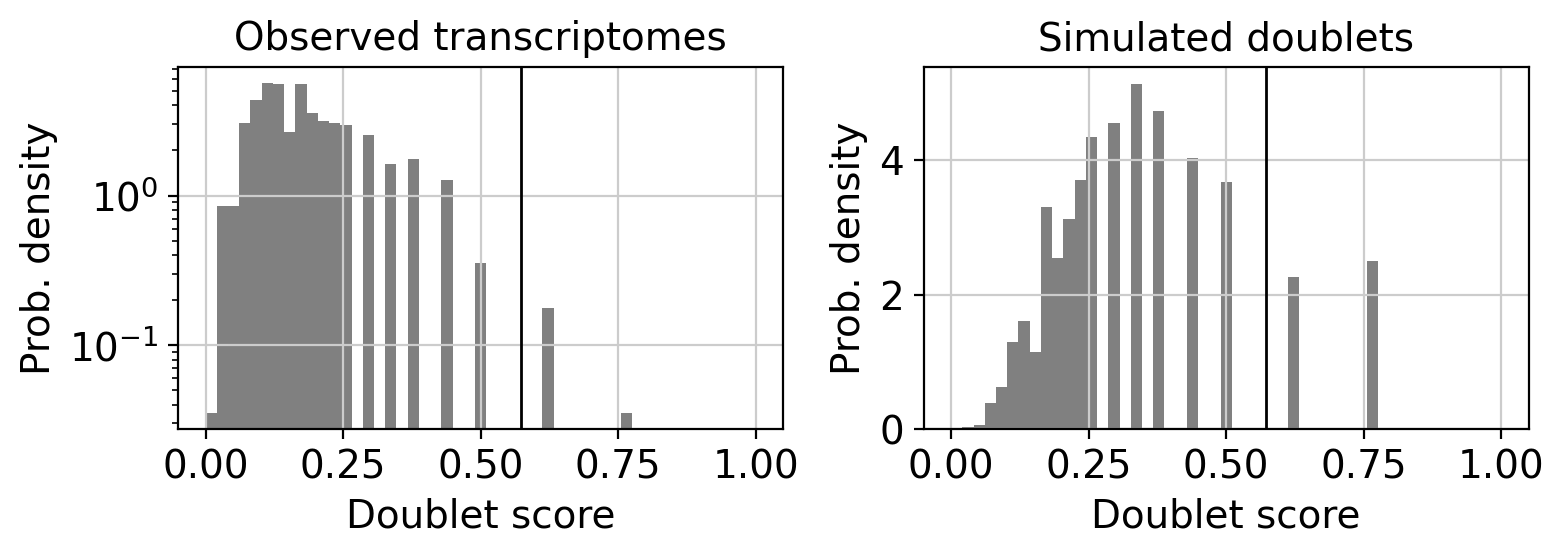

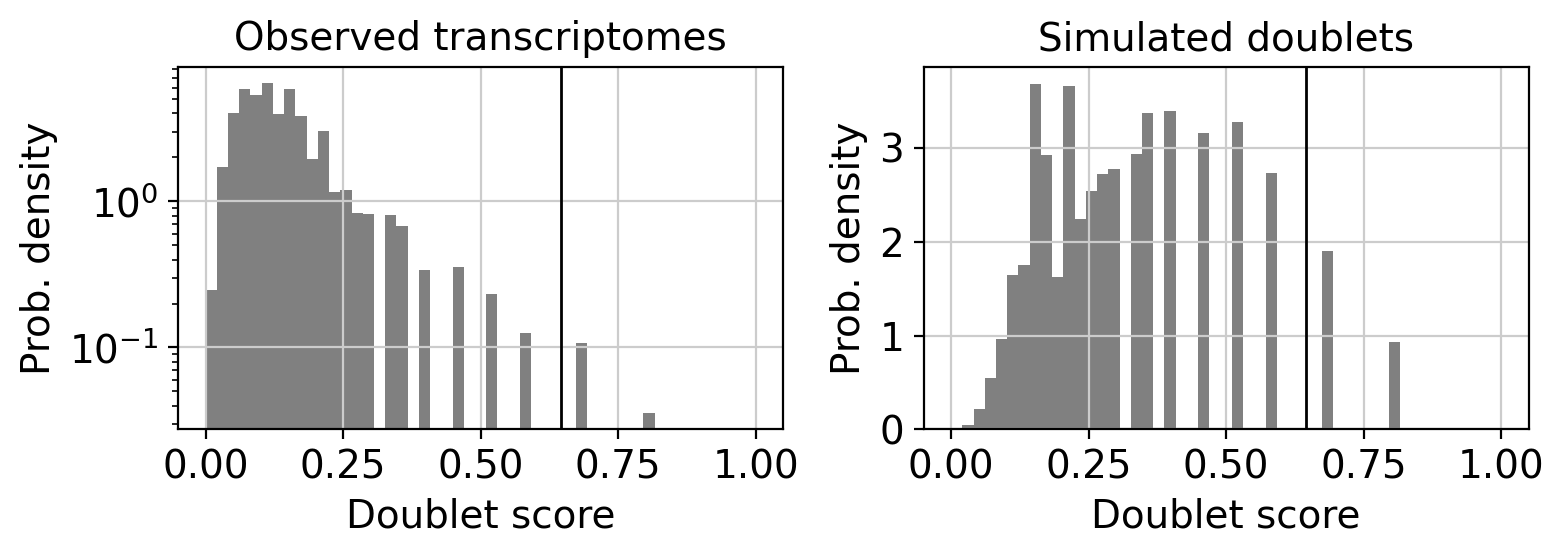

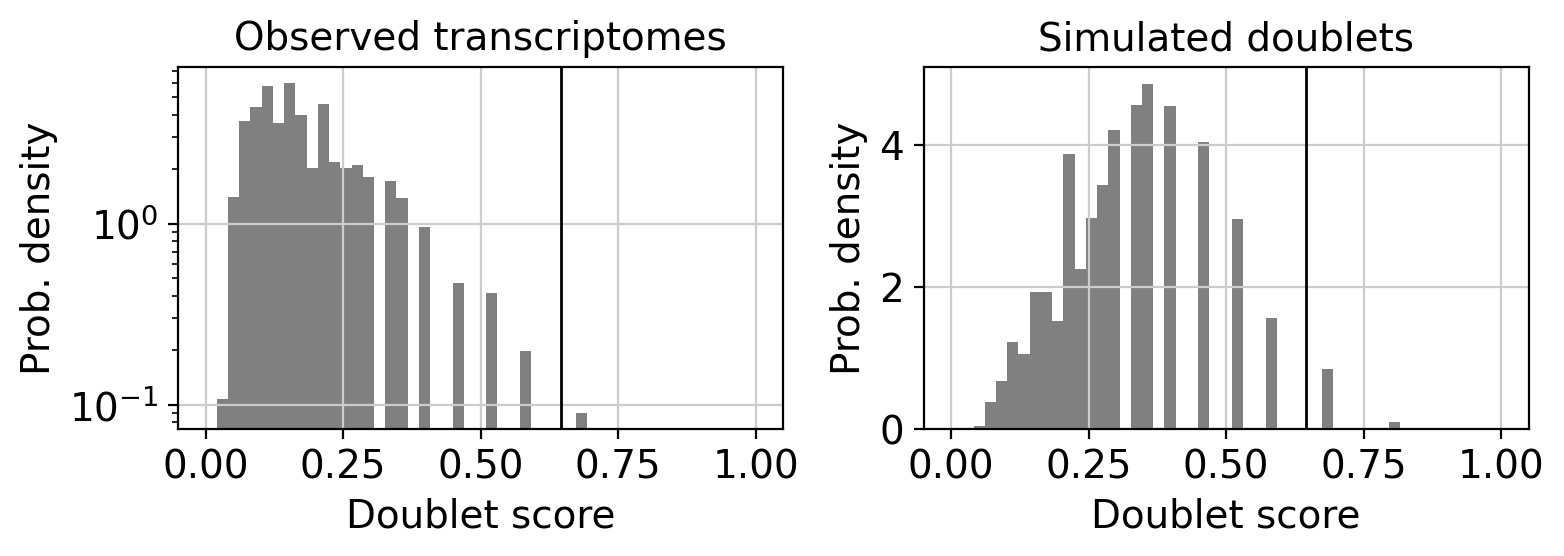

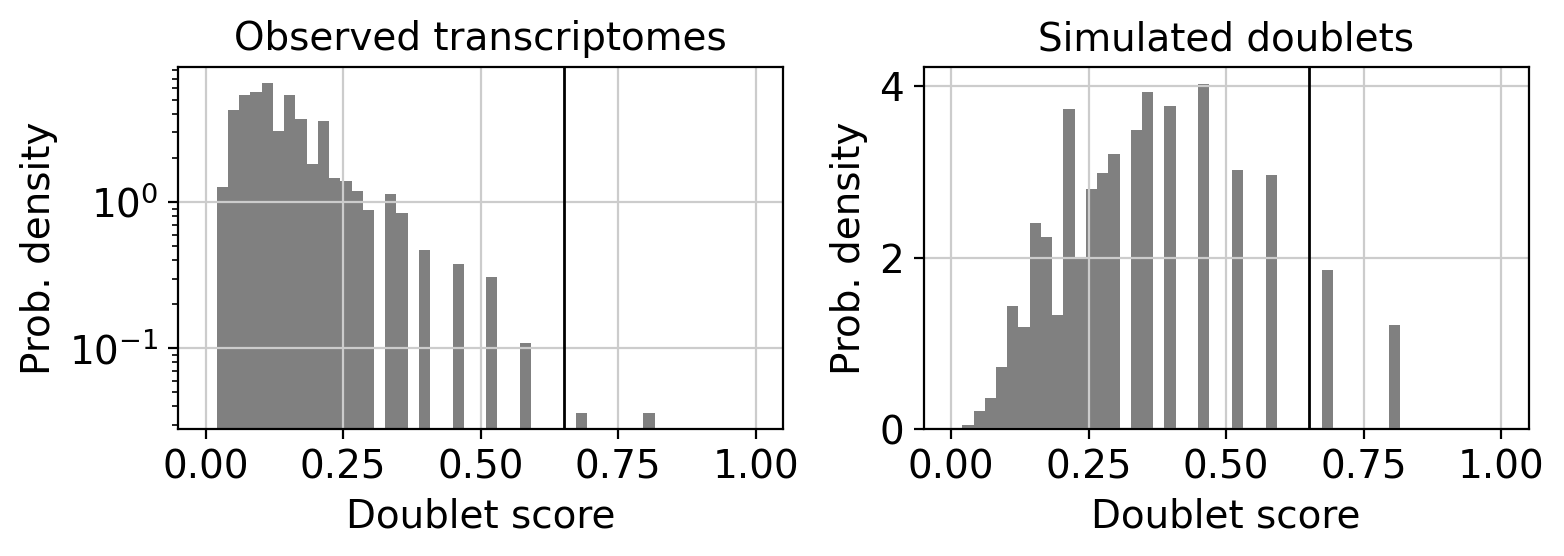

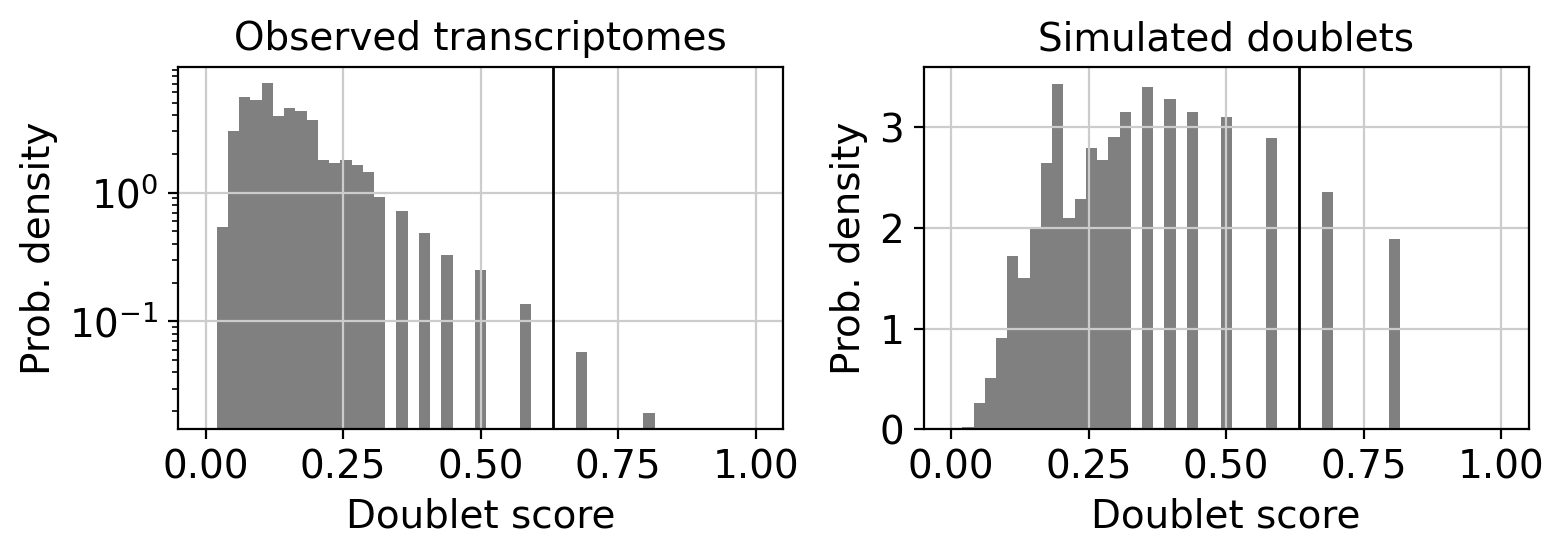

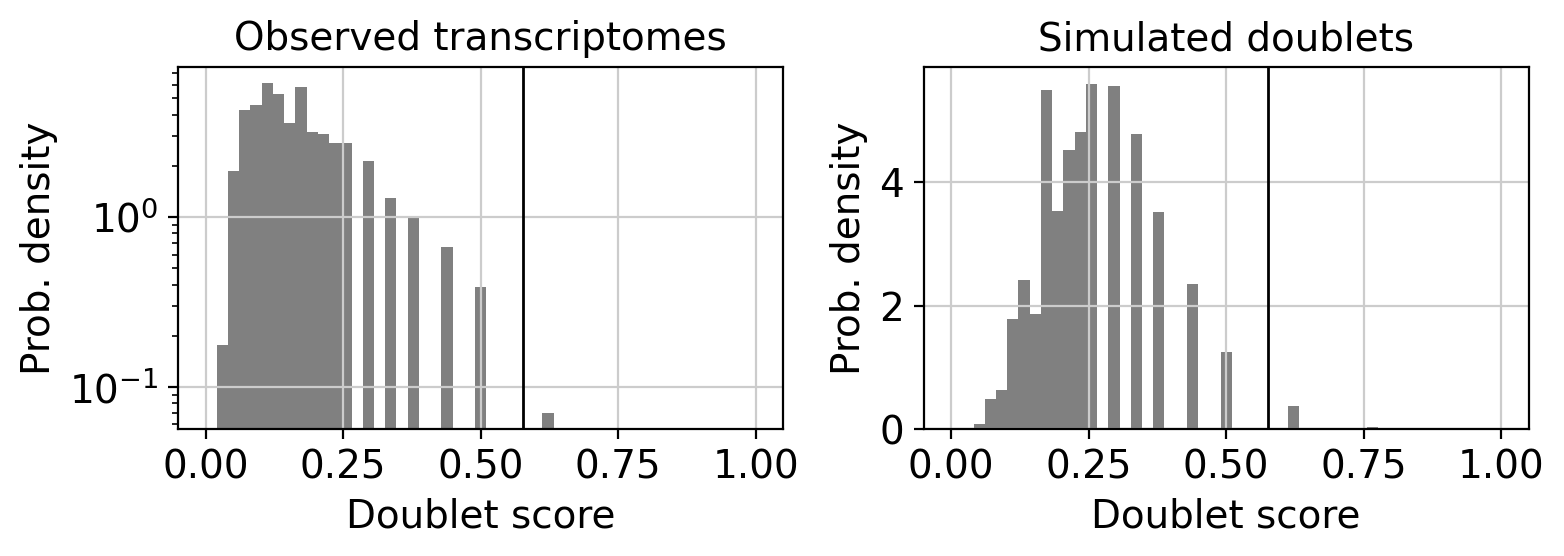

In [11]:
scrublet_concat = run_scrublet(
    adata, sample_col="Sample", cellbarcode_index_name="barcode"
)

In [12]:
scrublet_concat

,Sample,doublet_score,predicted_doublet
barcode,,,
P10_Liver_T2_GTTAGTGGTCGCATCG,P10_Liver_T2,0.160350,False
P10_Liver_T2_GCCATGGAGCAAGTCG,P10_Liver_T2,0.184466,False
P10_Liver_T2_AAGACTCGTCTTCGAA,P10_Liver_T2,0.066890,False
P10_Liver_T2_CCACGAGGTAACGTTC,P10_Liver_T2,0.232558,False
P10_Liver_T2_GGGACAAGTATTGACC,P10_Liver_T2,0.046025,False
...,...,...,...
P5_Liver_T1_GCACGGTTCCTAAACG,P5_Liver_T1,0.097744,False
P5_Liver_T1_GGTTGTAAGGGCTTCC,P5_Liver_T1,0.097744,False
P5_Liver_T1_TACTGCCCACAGACGA,P5_Liver_T1,0.140127,False


In [13]:
print(
    "Number of predicted doublets: ",
    scrublet_concat[scrublet_concat["predicted_doublet"] == True].shape[0],
)

Number of predicted doublets:  109


In [14]:
scrublet_concat.to_csv(
    DIR2SAVE.joinpath(scrublet_filename), sep="\t", index=True, header=True
)

In [15]:
## add scores to adata.obs
# add annot to .obs
adata.obs = adata.obs.merge(
    right=scrublet_concat[["doublet_score"]],
    how="left",
    right_index=True,
    left_index=True,
)

### Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

In [16]:
# find genes that are mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# find genes that are ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# compute QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=False, percent_top=None
)

In [17]:
print(
    adata.obs[
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]
    ].describe()
)

print(adata.var[["n_cells_by_counts", "total_counts"]].describe())

       n_genes_by_counts  total_counts  pct_counts_mt  pct_counts_ribo
count       55245.000000   55245.00000   55245.000000     55245.000000
mean         1148.044239    3377.94165       3.921350        24.087767
std           540.294928    3177.01709       3.534211         9.483231
min           201.000000     482.00000       0.000000         0.251256
25%           836.000000    1910.00000       1.995754        18.638239
50%          1057.000000    2655.00000       3.139149        24.750759
75%          1293.000000    3632.00000       4.991587        30.042240
max          6135.000000   64861.00000      81.949654        62.064404
       n_cells_by_counts  total_counts
count       20610.000000  2.061000e+04
mean         3077.326735  9.054556e+03
std          6527.773732  8.834851e+04
min             0.000000  0.000000e+00
25%            49.000000  5.300000e+01
50%           583.000000  6.530000e+02
75%          3139.000000  3.599750e+03
max         55165.000000  8.293125e+06


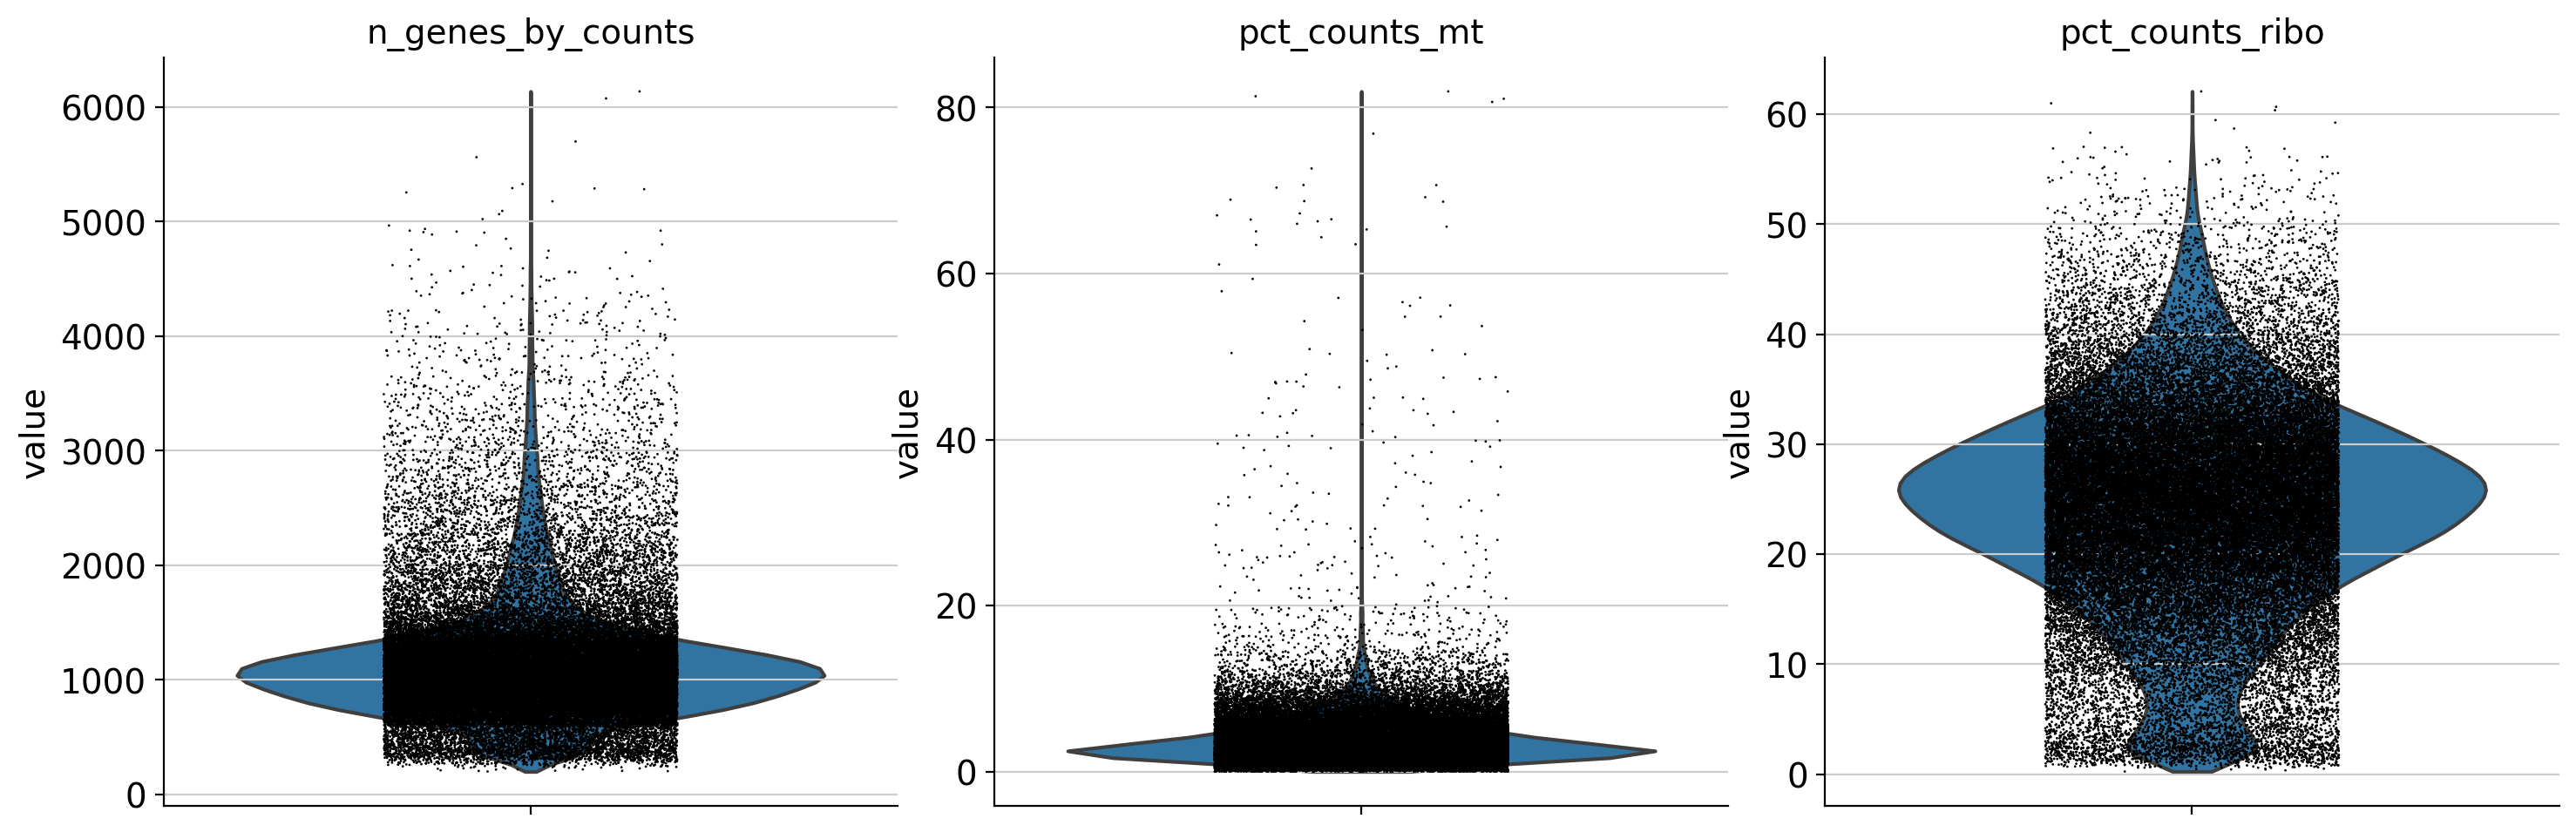

In [18]:
# violin plot of some distributions
sc.pl.violin(
    adata,
    keys=["n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.2,
    multi_panel=True,
    rotation=30,
    save="Wu2022_CRC_QC_covariates.pdf",
    show=True,
)

#### Filter cells according to identified QC thresholds:

* set threshold MT percent to 10%
* remove ribosomal and mitochondrial genes 
* remove cells with less than 300 genes

In [19]:
#### Filter cells according to identified QC thresholds:
print("Total number of cells: {:d}".format(adata.n_obs))

# remove cells with more than 20% MT genes
adata = adata[adata.obs.pct_counts_mt < 10, :].copy()
print("Number of cells after mt filter: {:d}".format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes=300)
print("Number of cells after gene filter: {:d}".format(adata.n_obs))

Total number of cells: 55245
Number of cells after mt filter: 53330
Number of cells after gene filter: 53129


#### Remove mt and ribo genes

In [20]:
print(adata.shape[1])
adata = adata[:, ~adata.var["mt"].values]
print("After mt genes removal: ", adata.shape[1])
adata = adata[:, ~adata.var["ribo"].values]
print("After ribo genes removal: ", adata.shape[1])

20610
After mt genes removal:  20597
After ribo genes removal:  20497


### Save to file 

In [21]:
adata.write(DIR2SAVE.joinpath("Wu2022_CRC_LM_raw_scrublet_qc.h5ad"))